# Price Embedded Option for HSBC Life Variable Annuity Product

## Steps:
1. Assumptions
2. Calculate GPB(nteed Payout Base) at the end of accumulation period (using Montecarlo Simulation Method and variance deduction technique)
3. Calculate every-month payout for payout period
4. Calculate product charge
5. Calculat present value 
6. Test different results with different initial investment and different accumulation/payout period

### Step1: Assumptions
(1) The underlying fund can be modelled by a Geometric Brownian motion with 𝜎 = 20% p.a. and 𝑟 = 3%;
(2) Accumulation Period is 15 years, and payout period is 20 years;
(3) No partial withdrawal during the policy
(4) Initial Investment is 51000 and 210000 respectively
(5) Policy begins at the begining of a month
(6) Annual fee is charged based on Monten Carlo simulation account value before payout 

### Step2: GPB at the end of accumulation period
### Step3: Calculate every-month payout for payout period

In [47]:
import numpy as np
#import openturns as ot
#import sobol_seq as seq
import matplotlib.pyplot as plt
np.random.seed(0)

In [73]:
def PayOut(simulationTimes, accumYears, initialInvestment,payOutYears):
    r = 0.03
    stv = 0.2
    d1 = accumYears*12 # how many times to simulate for each simulation during accumulation year
    d2 = payOutYears*12
    all_GPB = np.zeros(shape=(simulationTimes,d1+d2+1)) # all_GPB to store GPB calculation base for every month, +1 to store initial investment
    #all_GPB1 = np.zeros(shape=(simulationTimes,d1+d2+1))
    
    all_payOut = np.zeros(shape=(simulationTimes,d2))
    count1 = 0
    
    for count1 in range(simulationTimes):
        z = np.zeros(shape=(1,d1+d2+1))
        z[0,0:d1+d2] = np.random.normal(0, 1, size=(1, d1+d2))
        GPB_store = np.zeros(shape=(1,d1+d2+1))
        #GPB_store1 = np.zeros(shape=(1,d1+d2+1)) # one for storing GPB that is not deducted with payout for annual fee calculation
        
        GPB_store[0,0] = initialInvestment
        #GPB_store1[0,0] = initialInvestment
        
        count2 = 0
        
        # Calculate GPB during the accumulation years
        for count2 in range(d1+1):
            F1 = GPB_store[0,count2]*np.exp((r-0.5*stv*stv)*(1/12)+stv*np.sqrt(1/12)*z[0,count2])
            if count2 <= d1-1:# why needs this? when d1=3, count2=3,  F1 is out of what we need
                GPB_store[0,count2+1]= F1  
                #GPB_store1[0,count2+1]= F1
            count2 +=1
          
        # Calculate GPB and payout for every month during the payout years
        count3 = d1+1
        RemainMonths = payOutYears*12
        payOut = np.zeros(shape=(1,d2))#d2-1,cuz pay at initial of every month
        
        GPB = np.max(GPB_store) # as payout base of first month
        payout_everymonth = GPB/RemainMonths
        payOut[0,0] = payout_everymonth
        
        for count3 in range(d1+1, d1+d2+1):
            GPB_afterPay = GPB_store[0, count3-1] - payout_everymonth
            F2 = GPB_afterPay*np.exp((r-0.5*stv*stv)*(1/12)+stv*np.sqrt(1/12)*z[0,count3-1]) # next month GPB includes payout here
            
            #F2_1 =  GPB_store[0,count3]*np.exp((r-0.5*stv*stv)*(1/12)+stv*np.sqrt(1/12)*z[0,count3])           
            #GPB_store1[0,count3]= F2_1
            
            if count3 <= d1+d2-1:
                GPB_store[0,count3]= F2 # 如果要基于增长的GBP收年费，那么这里要比较一下再输入
                
            if RemainMonths != 1:
                if GPB_store[0,count3] > GPB_store[0,count3-1]: # 和jinglong不同点，我是payout的时候每个月对比上一次的，他是和第一次比，而且他没有有每月减掉payout作为新的蒙特卡洛模拟基数
                    payout_everymonth = GPB_store[0, count3]/(RemainMonths-1)
                    #RemainMonths = RemainMonths - 1
                else:
                    payout_everymonth = payOut[0,count3-d1-1]
            else:
                payout_everymonth = GPB_store[0, d1+d2-1]# when remainMonths=0, count3=d1+d2, pay out lump sum payout
            #print("payout_everymonth is: ", payout_everymonth)
            if count3 <= d1+d2-1:
                payOut[0,count3-d1] = payout_everymonth # count3-d1-1 at first round is 0             
            count3 = count3+1 
            RemainMonths = RemainMonths-1
    
        all_GPB[count1,:]= GPB_store
        all_payOut[count1,:]= payOut
        count1 +=1
                                     
    return all_GPB, all_payOut

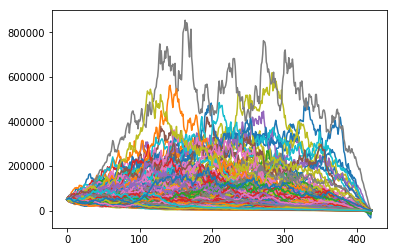

In [75]:
x = np.arange(0,421,1)
AccountValue = PayOut(10000, 10, 51000, 25)[0].T
AccountValue.shape
for i in range(0,421):
    y = AccountValue[:,i]
    plt.plot(x,y)

plt.show()

### Step4: Calculate product charge

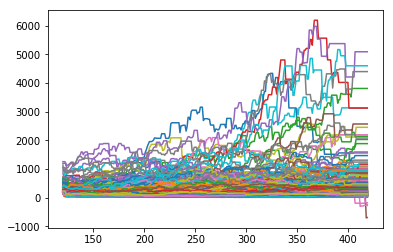

In [84]:
x = np.arange(120,420,1)
Payout = PayOut(10000, 10, 51000, 25)[1].T
for i in range(0,300):
    y = Payout[:,i]
    plt.plot(x,y)

plt.show()

### Step5: Calculat PV
    

In [24]:
def PV_avg(simulationTimes, accumYears, initialInvestment,payOutYears,ini_ChargeRate,MaintenanceRate):
    # present value of the payout
    r = 0.03
    d1 = accumYears*12
    d2 = payOutYears*12
    a,b = PayOut(simulationTimes, accumYears, initialInvestment,payOutYears)
    all_GPB = a
    all_payout = b
    charge_sum_each=np.zeros(shape=(1,simulationTimes))
    pv_sum_each = np.zeros(shape=(1,simulationTimes))
    # PV
    charge_oneTime = initialInvestment*ini_ChargeRate # 设置费率
    
    for i in range(simulationTimes):
        charge_sum = 0
        pv_sum = 0
        J = accumYears+payOutYears
        # calculate charge
        for j in range(1,J):
            charge = all_GPB[i,j*12]*MaintenanceRate*np.exp(-r*j) #年费不是月费,在月末还是月初付？第2年年初和第35年年初付
            charge_sum = charge_sum + charge
        charge_sum_each[0,i]=charge_sum   
        # calculate payoff
        for j in range(d2):
            pv = all_payout[i,j]*np.exp(-r*(accumYears+j/12))
            pv_sum = pv_sum + pv
        
        pv_sum_each[0,i]=pv_sum # pv_sum_each is storing payout pv for each simulation
        
    return pv_sum_each-charge_sum_each-charge_oneTime-initialInvestment
    #return charge_sum_each

### Step6: Test Different Schemes

#### From the simulation result, we can conclude that no matter which scheme clients choose, this product will earn profit for HSBC under the mentioned assumptions

In [25]:
print("When premium amount is less than 199000 ($51000): \nOption Value With 10-year accumulation period and 25-year payout period:")
print(np.mean(PV_avg(10000,10,51000,25,0.08,0.0295)))
print("Option Value With 15-year accumulation period and 25-year payout period: ")
print(np.mean(PV_avg(10000,15,51000,25,0.08,0.0295)))
print("Option Value With 15-year accumulation period and 25-year payout period: ")
print(np.mean(PV_avg(10000,20,51000,20,0.08,0.0295)))

When premium amount is less than 199000 ($51000): 
Option Value With 10-year accumulation period and 25-year payout period:
-2745.195863271566
Option Value With 15-year accumulation period and 25-year payout period: 
-4364.008834351892
Option Value With 15-year accumulation period and 25-year payout period: 
-4654.88879267385


In [26]:
print("When premium amount is less than 199000 ($200000): \nOption Value With 10-year accumulation period and 25-year payout period:")
print(np.mean(PV_avg(10000,10,200000,25,0.07,0.0275)))
print("Option Value With 15-year accumulation period and 25-year payout period: ")
print(np.mean(PV_avg(10000,15,200000,25,0.07,0.0275)))
print("Option Value With 20-year accumulation period and 25-year payout period: ")
print(np.mean(PV_avg(10000,20,200000,20,0.07,0.0275)))

When premium amount is less than 199000 ($200000): 
Option Value With 10-year accumulation period and 25-year payout period:
-17483.290792812186
Option Value With 15-year accumulation period and 25-year payout period: 
-13347.702824807573
Option Value With 15-year accumulation period and 25-year payout period: 
-4918.844511468575
